# The Lorenz Attractor: A Journey into Chaos Theory

**Mathematical Modeling Applications - Problem Solving Session**

---

## Introduction

Today we're going to explore one of the most famous systems in chaos theory: the **Lorenz Attractor**. This system was discovered by Edward Lorenz in 1963 while he was studying atmospheric convection patterns for weather prediction.

**Why is this important?**
- It was one of the first examples of **deterministic chaos** - a system governed by deterministic equations but exhibiting unpredictable behavior
- Lorenz coined the term **"Butterfly Effect"** to describe sensitive dependence on initial conditions
- It revolutionized our understanding of nonlinear dynamics and put limits on long-term weather forecasting

**What we'll cover:**
1. The mathematical formulation of the Lorenz system
2. Understanding equilibrium points
3. Numerical integration using the RK4 method
4. Visualizing chaos in 3D
5. Demonstrating the butterfly effect

Let's dive in!

## 1. The Lorenz System: Mathematical Formulation

The Lorenz system consists of three coupled ordinary differential equations (ODEs):

$$
\begin{align}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align}
$$

**Physical Interpretation:**
- $x$: Rate of convection (how fast air is rotating)
- $y$: Horizontal temperature variation
- $z$: Vertical temperature variation

**Parameters:**
- $\sigma$ (sigma): Prandtl number - ratio of viscosity to thermal conductivity (typically 10)
- $\rho$ (rho): Rayleigh number - temperature difference driving convection (typically 28)
- $\beta$ (beta): Geometric factor related to the physical dimensions (typically 8/3)

**Key Point to Emphasize:** These are nonlinear ODEs (notice the $xy$, $xz$ terms), which is what allows chaotic behavior to emerge!

### Import Libraries

First, let's import the libraries we'll need. We'll use:
- `numpy` for numerical computations
- `matplotlib` for 2D plotting
- `mpl_toolkits.mplot3d` for 3D visualization

In [1]:
from numpy import zeros, sqrt, linspace, log
from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend, show
from mpl_toolkits.mplot3d import Axes3D

### Implementing the Right-Hand Side Functions

Let's implement each of the three differential equations as separate functions. This makes our code modular and easier to understand.

**Teaching Note:** Explain that we're breaking down the system into its components - each function represents one equation.

In [2]:
def lorenz_x_dot(x, y, z, sigma=10.0):
    """
    First equation: dx/dt = σ(y - x)
    
    This represents the rate of change of convection.
    When y > x, the system tries to increase x (and vice versa).
    The parameter sigma controls how quickly this happens.
    """
    return sigma * (y - x)


def lorenz_y_dot(x, y, z, rho=28.0):
    """
    Second equation: dy/dt = x(ρ - z) - y
    
    This couples the horizontal and vertical temperature variations.
    Notice the nonlinear term x*z - this is crucial for chaos!
    """
    return x * (rho - z) - y


def lorenz_z_dot(x, y, z, beta=8.0/3.0):
    """
    Third equation: dz/dt = xy - βz
    
    This describes how the vertical temperature profile evolves.
    Another nonlinear term: x*y
    The -βz term acts as damping.
    """
    return x * y - beta * z

## 2. Equilibrium Points

Before we solve the system numerically, let's understand its equilibrium points. An equilibrium (or fixed point) is where all derivatives are zero:

$$\frac{dx}{dt} = \frac{dy}{dt} = \frac{dz}{dt} = 0$$

**Mathematical Analysis:**

Setting the right-hand sides to zero and solving, we find **three equilibrium points**:

1. **Origin**: $(0, 0, 0)$ - Always exists

2. **C+**: $(\sqrt{\beta(\rho-1)}, \sqrt{\beta(\rho-1)}, \rho-1)$ - Exists when $\rho > 1$

3. **C-**: $(-\sqrt{\beta(\rho-1)}, -\sqrt{\beta(\rho-1)}, \rho-1)$ - Exists when $\rho > 1$

**Important Insight:** 
- For $\rho < 1$: Only the origin exists and is stable
- For $1 < \rho < 24.74$: C+ and C- are stable
- For $\rho > 24.74$: All three equilibria become unstable → **CHAOS!**

Our choice of $\rho = 28$ puts us firmly in the chaotic regime.

In [3]:
def equilibria(sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Calculate the three equilibrium points of the Lorenz system.
    
    Returns:
        Three tuples representing (x, y, z) coordinates of equilibria
    """
    # Origin - always exists
    eq0 = (0.0, 0.0, 0.0)
    
    # C+ and C- exist only when rho > 1
    if rho > 1:
        val = sqrt(beta * (rho - 1))
        eq_plus = (val, val, rho - 1)
        eq_minus = (-val, -val, rho - 1)
        return eq0, eq_plus, eq_minus
    else:
        return eq0, None, None


# Calculate and display the equilibria for our parameters
eq0, eq_plus, eq_minus = equilibria()
print("Equilibrium Points for σ=10, ρ=28, β=8/3:")
print(f"  Origin:  {eq0}")
print(f"  C+:      ({eq_plus[0]:.3f}, {eq_plus[1]:.3f}, {eq_plus[2]:.3f})")
print(f"  C-:      ({eq_minus[0]:.3f}, {eq_minus[1]:.3f}, {eq_minus[2]:.3f})")
print("\n[Teaching point: The trajectory will spiral around C+ and C- unpredictably!]")

Equilibrium Points for σ=10, ρ=28, β=8/3:
  Origin:  (0.0, 0.0, 0.0)
  C+:      (8.485, 8.485, 27.000)
  C-:      (-8.485, -8.485, 27.000)

[Teaching point: The trajectory will spiral around C+ and C- unpredictably!]


## 3. Numerical Integration: The RK4 Method

Now we need to solve these ODEs numerically. We can't solve them analytically (there's no closed-form solution), so we use numerical methods.

### Why RK4?

The **Fourth-Order Runge-Kutta (RK4)** method is the gold standard for ODE integration because:
- It's **fourth-order accurate**: local error is $O(h^5)$, global error is $O(h^4)$
- It's **stable** for a wide range of problems
- It's **efficient**: good accuracy with reasonable computational cost

### The RK4 Formula

For a general ODE $\frac{dy}{dt} = f(t, y)$, one RK4 step from $y_n$ to $y_{n+1}$ is:

$$
\begin{align}
k_1 &= h \cdot f(t_n, y_n) \\
k_2 &= h \cdot f(t_n + h/2, y_n + k_1/2) \\
k_3 &= h \cdot f(t_n + h/2, y_n + k_2/2) \\
k_4 &= h \cdot f(t_n + h, y_n + k_3) \\
y_{n+1} &= y_n + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{align}
$$

**Intuition:** 
- $k_1$: slope at the beginning of the interval
- $k_2, k_3$: two estimates of the slope at the midpoint
- $k_4$: slope at the end of the interval
- We take a **weighted average** with more weight on the midpoint estimates

**For our 3D system**, we apply this formula to all three variables $(x, y, z)$ simultaneously.

In [4]:
def rk4_step(x, y, z, dt, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Perform one RK4 step for the Lorenz system.
    
    Parameters:
        x, y, z: Current state
        dt: Time step size
        sigma, rho, beta: System parameters
    
    Returns:
        x_new, y_new, z_new: State after one time step
    """
    # k1: Evaluate derivatives at current point
    k1x = dt * lorenz_x_dot(x, y, z, sigma)
    k1y = dt * lorenz_y_dot(x, y, z, rho)
    k1z = dt * lorenz_z_dot(x, y, z, beta)
    
    # k2: Evaluate at midpoint using k1
    k2x = dt * lorenz_x_dot(x + 0.5*k1x, y + 0.5*k1y, z + 0.5*k1z, sigma)
    k2y = dt * lorenz_y_dot(x + 0.5*k1x, y + 0.5*k1y, z + 0.5*k1z, rho)
    k2z = dt * lorenz_z_dot(x + 0.5*k1x, y + 0.5*k1y, z + 0.5*k1z, beta)
    
    # k3: Evaluate at midpoint using k2
    k3x = dt * lorenz_x_dot(x + 0.5*k2x, y + 0.5*k2y, z + 0.5*k2z, sigma)
    k3y = dt * lorenz_y_dot(x + 0.5*k2x, y + 0.5*k2y, z + 0.5*k2z, rho)
    k3z = dt * lorenz_z_dot(x + 0.5*k2x, y + 0.5*k2y, z + 0.5*k2z, beta)
    
    # k4: Evaluate at endpoint using k3
    k4x = dt * lorenz_x_dot(x + k3x, y + k3y, z + k3z, sigma)
    k4y = dt * lorenz_y_dot(x + k3x, y + k3y, z + k3z, rho)
    k4z = dt * lorenz_z_dot(x + k3x, y + k3y, z + k3z, beta)
    
    # Combine with weighted average: (k1 + 2k2 + 2k3 + k4)/6
    x_new = x + (k1x + 2*(k2x + k3x) + k4x) / 6.0
    y_new = y + (k1y + 2*(k2y + k3y) + k4y) / 6.0
    z_new = z + (k1z + 2*(k2z + k3z) + k4z) / 6.0
    
    return x_new, y_new, z_new

### Creating the Solver

Now let's create a function that applies RK4 repeatedly to solve the system over many time steps.

In [5]:
def solve_lorenz(x0, y0, z0, M, dt, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """
    Solve the Lorenz system using RK4.
    
    Parameters:
        x0, y0, z0: Initial conditions
        M: Number of time steps
        dt: Time step size
        sigma, rho, beta: System parameters
    
    Returns:
        x, y, z: Arrays of length M+1 containing the solution
    """
    # Initialize arrays to store the solution
    x = zeros(M + 1)
    y = zeros(M + 1)
    z = zeros(M + 1)
    
    # Set initial conditions
    x[0], y[0], z[0] = x0, y0, z0
    
    # Integrate forward in time
    for i in range(M):
        x[i+1], y[i+1], z[i+1] = rk4_step(x[i], y[i], z[i], dt, sigma, rho, beta)
    
    return x, y, z

print("Solver function ready! Let's see what chaos looks like...")

Solver function ready! Let's see what chaos looks like...


## 4. Visualizing the Lorenz Attractor in 3D

Now for the exciting part - let's visualize the famous "butterfly" shape!

**Teaching Points:**
- We start from initial condition $(1, 1, 1)$
- We'll integrate for 10,000 time steps with $dt = 0.01$ (total time = 100 units)
- The trajectory spirals around both C+ and C-, creating the butterfly wings
- The trajectory NEVER repeats but stays bounded - this is a **strange attractor**

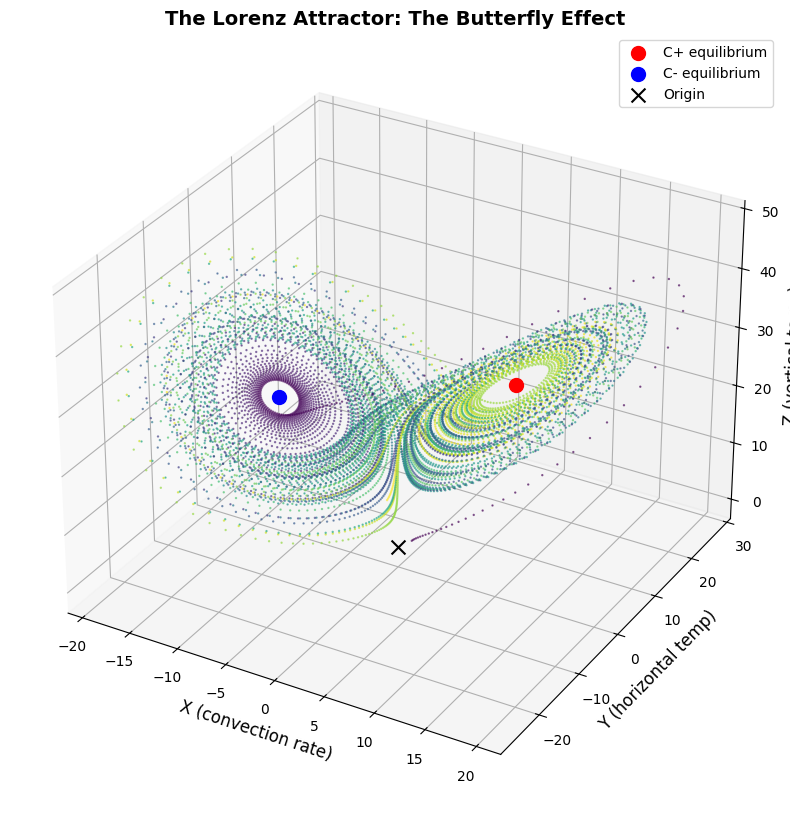


[Point out: The trajectory spirals around C+ and C- unpredictably!]
[This is a STRANGE ATTRACTOR - bounded but never repeating]


In [36]:
# Solve the system
# x, y, z = solve_lorenz(x0=1.0, y0=1.0, z0=1.0, M=10000, dt=0.01, rho=23.7)
# x, y, z = solve_lorenz(x0=1.0, y0=1.0, z0=1.0, M=10000, dt=0.01, rho=23.8)
x, y, z = solve_lorenz(x0=1.0, y0=1.0, z0=1.0, M=10000, dt=0.01, rho=28)

# Create 3D plot
fig = figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory with a color gradient showing time progression
n_points = len(x)
colors = range(n_points)
ax.scatter(x, y, z, c=colors, cmap='viridis', s=0.5, alpha=0.6)

# Mark the equilibrium points
if eq_plus and eq_minus:
    ax.scatter(*eq_plus, c='red', s=100, marker='o', label='C+ equilibrium')
    ax.scatter(*eq_minus, c='blue', s=100, marker='o', label='C- equilibrium')
    ax.scatter(*eq0, c='black', s=100, marker='x', label='Origin')

ax.set_xlabel('X (convection rate)', fontsize=12)
ax.set_ylabel('Y (horizontal temp)', fontsize=12)
ax.set_zlabel('Z (vertical temp)', fontsize=12)
ax.set_title('The Lorenz Attractor: The Butterfly Effect', fontsize=14, fontweight='bold')
ax.legend()

show()

print("\n[Point out: The trajectory spirals around C+ and C- unpredictably!]")
print("[This is a STRANGE ATTRACTOR - bounded but never repeating]")

In [17]:
import plotly.graph_objects as go

# Solve the system
x, y, z = solve_lorenz(x0=1.0, y0=1.0, z0=1.0, M=10000, dt=0.01)

# Create interactive plotly figure
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=list(range(len(x))),
        colorscale='Viridis',
        opacity=0.6,
        showscale=True,
        colorbar=dict(title="Time")
    ),
    name='Trajectory'
)])

# Add equilibrium points
if eq_plus and eq_minus:
    fig.add_trace(go.Scatter3d(
        x=[eq_plus[0]], y=[eq_plus[1]], z=[eq_plus[2]],
        mode='markers',
        marker=dict(size=8, color='red', symbol='diamond'),
        name='C+ equilibrium'
    ))
    fig.add_trace(go.Scatter3d(
        x=[eq_minus[0]], y=[eq_minus[1]], z=[eq_minus[2]],
        mode='markers',
        marker=dict(size=8, color='blue', symbol='diamond'),
        name='C- equilibrium'
    ))
    fig.add_trace(go.Scatter3d(
        x=[eq0[0]], y=[eq0[1]], z=[eq0[2]],
        mode='markers',
        marker=dict(size=8, color='black', symbol='x'),
        name='Origin'
    ))

fig.update_layout(
    title='The Lorenz Attractor: The Butterfly Effect',
    scene=dict(
        xaxis_title='X (convection rate)',
        yaxis_title='Y (horizontal temp)',
        zaxis_title='Z (vertical temp)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1400,
    height=900,
    showlegend=True
)

fig.show()

print("\n🖱️  INTERACTIVE: Click and drag to rotate! Scroll to zoom! Double-click to reset!")
print("\n[Point out: The trajectory spirals around C+ and C- unpredictably!]")
print("[This is a STRANGE ATTRACTOR - bounded but never repeating]")


🖱️  INTERACTIVE: Click and drag to rotate! Scroll to zoom! Double-click to reset!

[Point out: The trajectory spirals around C+ and C- unpredictably!]
[This is a STRANGE ATTRACTOR - bounded but never repeating]


## 5. Time Series: Observing Chaos

Let's look at how one variable (say, $z$) changes over time. This reveals the chaotic switching between the two "wings" of the butterfly.

**What to look for:**
- Irregular oscillations
- The system switches unpredictably between high and low values
- No visible period - this is **aperiodic** behavior

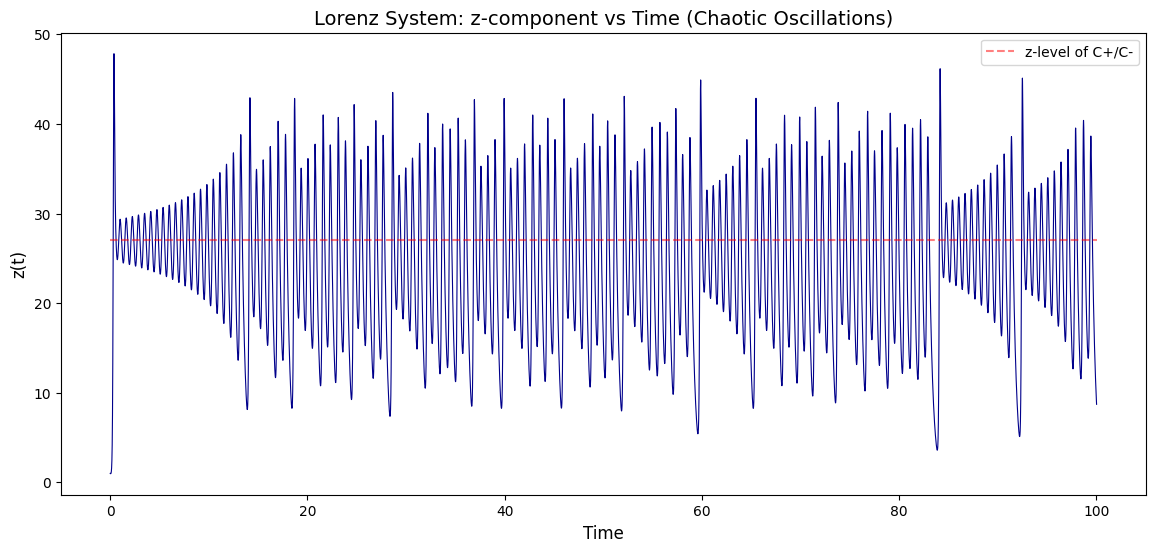


[Emphasize: Notice how z oscillates irregularly around the equilibrium height]
[When z is high, the system is near one wing; when low, it's transitioning]


In [7]:
# Create time array
t = linspace(0, len(z)*0.01, len(z))

# Plot z(t)
figure(figsize=(14, 6))
plot(t, z, linewidth=0.8, color='darkblue')
xlabel('Time', fontsize=12)
ylabel('z(t)', fontsize=12)
title('Lorenz System: z-component vs Time (Chaotic Oscillations)', fontsize=14)

# Add horizontal line at z = rho - 1 (the z-coordinate of C+ and C-)
plot([t[0], t[-1]], [27, 27], 'r--', alpha=0.5, label='z-level of C+/C-')
legend()
show()

print("\n[Emphasize: Notice how z oscillates irregularly around the equilibrium height]")
print("[When z is high, the system is near one wing; when low, it's transitioning]")

## 6. The Butterfly Effect: Sensitive Dependence on Initial Conditions

This is perhaps the most famous property of chaotic systems. Let's demonstrate it!

**Experiment:**
- Run two simulations with nearly identical initial conditions
- First: $(1.0, 1.0, 1.0)$
- Second: $(1.001, 1.0, 1.0)$ - only 0.1% difference!

**Question for students:** What do you think will happen? Will they stay close together?

**Answer:** No! They diverge exponentially. This is why long-term weather prediction is impossible - tiny measurement errors grow exponentially!

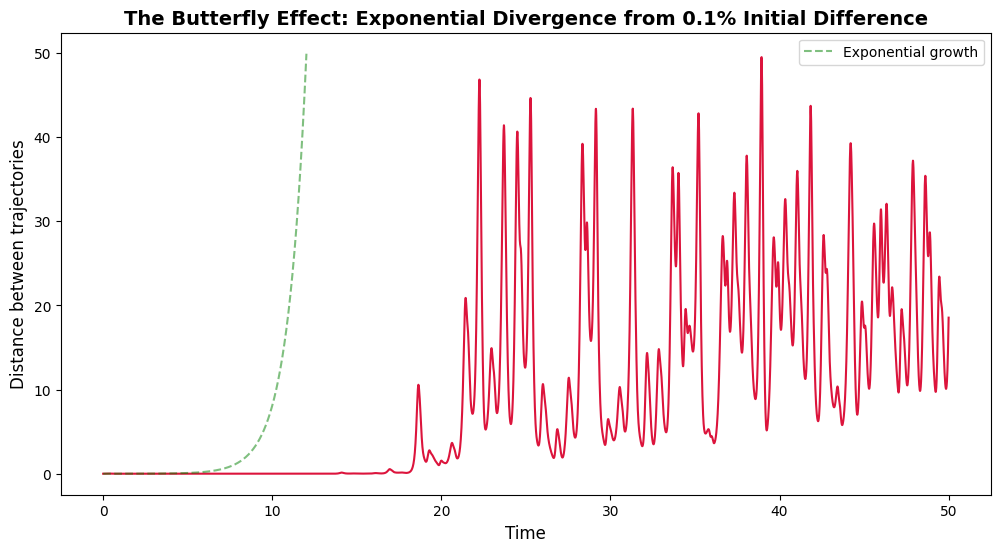


Initial distance: 0.001000
Final distance: 18.55
Growth factor: 1.9e+04x

[Key point: The distance grows EXPONENTIALLY at first, then saturates]
[Lyapunov exponent ≈ 0.9: errors grow by e^(0.9*t)]


In [8]:
# Solve for two nearby initial conditions
x1, y1, z1 = solve_lorenz(1.0, 1.0, 1.0, 5000, 0.01)
x2, y2, z2 = solve_lorenz(1.001, 1.0, 1.0, 5000, 0.01)  # Only 0.1% difference!

# Calculate Euclidean distance between trajectories at each time step
distance = sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

# Time array
t_butterfly = linspace(0, 5000*0.01, 5001)

# Plot the divergence
figure(figsize=(12, 6))
plot(t_butterfly, distance, linewidth=1.5, color='crimson')
xlabel('Time', fontsize=12)
ylabel('Distance between trajectories', fontsize=12)
title('The Butterfly Effect: Exponential Divergence from 0.1% Initial Difference', fontsize=14, fontweight='bold')

# Add reference line for exponential growth
import numpy as np
exponential_fit = distance[0] * np.exp(0.9 * t_butterfly)  # Approximate Lyapunov exponent
mask = exponential_fit < 50  # Only show while exponential
plot(t_butterfly[mask], exponential_fit[mask], 'g--', alpha=0.5, label='Exponential growth')
legend()
show()

# Print statistics
print(f"\nInitial distance: {distance[0]:.6f}")
print(f"Final distance: {distance[-1]:.2f}")
print(f"Growth factor: {distance[-1]/distance[0]:.1e}x")
print(f"\n[Key point: The distance grows EXPONENTIALLY at first, then saturates]")
print(f"[Lyapunov exponent ≈ 0.9: errors grow by e^(0.9*t)]")

## 7. 2D Projections: Understanding the Structure

Sometimes it's easier to understand 3D structures by looking at 2D projections. Let's look at all three possible projections.

**Teaching point:** Each projection reveals different aspects of the attractor's geometry.

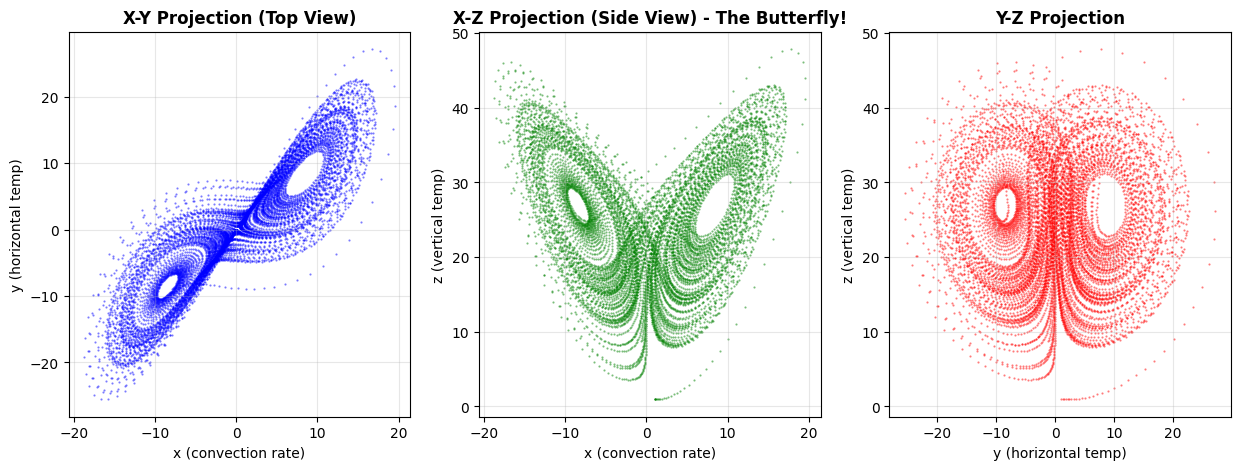


[Point out: The X-Z projection shows the 'butterfly wings' most clearly]
[Each wing corresponds to orbiting around one equilibrium (C+ or C-)]


In [9]:
# Create figure with three subplots
fig = figure(figsize=(15, 5))

# X-Y projection (top view)
ax1 = fig.add_subplot(131)
ax1.scatter(x, y, s=0.3, alpha=0.5, c='blue')
ax1.set_xlabel('x (convection rate)', fontsize=10)
ax1.set_ylabel('y (horizontal temp)', fontsize=10)
ax1.set_title('X-Y Projection (Top View)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# X-Z projection (side view) - This shows the "butterfly" best!
ax2 = fig.add_subplot(132)
ax2.scatter(x, z, s=0.3, alpha=0.5, c='green')
ax2.set_xlabel('x (convection rate)', fontsize=10)
ax2.set_ylabel('z (vertical temp)', fontsize=10)
ax2.set_title('X-Z Projection (Side View) - The Butterfly!', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Y-Z projection
ax3 = fig.add_subplot(133)
ax3.scatter(y, z, s=0.3, alpha=0.5, c='red')
ax3.set_xlabel('y (horizontal temp)', fontsize=10)
ax3.set_ylabel('z (vertical temp)', fontsize=10)
ax3.set_title('Y-Z Projection', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

show()

print("\n[Point out: The X-Z projection shows the 'butterfly wings' most clearly]")
print("[Each wing corresponds to orbiting around one equilibrium (C+ or C-)]")

## 8. Summary and Key Takeaways

Let's recap what we've learned about the Lorenz system:

### Mathematical Properties:
1. **Nonlinear ODEs**: The system has nonlinear terms ($xz$, $xy$) that enable chaos
2. **Three equilibria**: Origin, C+, and C- (for $\rho > 1$)
3. **Chaotic regime**: For $\rho > 24.74$, all equilibria are unstable

### Numerical Methods:
1. **RK4 integration**: Fourth-order accuracy, good stability
2. **Step size**: $dt = 0.01$ is small enough to capture the dynamics accurately

### Chaos Theory:
1. **Strange attractor**: Bounded but never repeating trajectory
2. **Butterfly effect**: Exponential sensitivity to initial conditions
3. **Lyapunov exponent**: $\lambda \approx 0.9$ quantifies the rate of divergence
4. **Deterministic but unpredictable**: The equations are deterministic, but long-term prediction is impossible

### Practical Implications:
- **Weather forecasting**: This is why we can't predict weather more than ~10 days ahead
- **Climate vs. weather**: We can predict climate (averages) but not specific weather events
- **Chaos is everywhere**: Similar dynamics appear in fluid flow, chemical reactions, population dynamics, economics, etc.

---

### Questions for Discussion:
1. What happens if we change $\rho$ to 20? To 30?
2. Can you find any periodic orbits in this system?
3. How would you compute the Lyapunov exponent more accurately?
4. What other systems in nature exhibit chaotic behavior?

---

**Great job! You now understand one of the most important systems in nonlinear dynamics! 🦋**